# Image Segmentation: TransUNet 2.5D [Train] [TF]


# A. Methodlogy 🎯
* In this notebook I'll demonstrate **2.5D** image Training for Segmentation with tf.data, tfrecord using Tensorflow.

* In a nutshell, **2.5D Image Training** is training of 3D image like 2D Image. More about 2.5D training is discussed later. 2.5D images can take leverage of the extra depth information like our typical RGB image. In this notebook I'll be using 3 channels with 2 strides for 2.5D images
* In this notebook, I'll be also re-implementing TransUNet: Transformers Make Strong Encoders for Medical Image Segmentation Model using Tensorflow.
* TFRecord dataset for **Segmentation** is created using UWMGI: 2.5D TFRecord Data notebook.
* TFRecord files are created using StratifiedGroupFold to avoid data leakage due to case and to stratify empty and non-empty mask cases.
* This notebook is compatible for both GPU and TPU. Device is automatically selected so you won't have to do anything to allocate device.
* As there are overlaps between Stomach, Large Bowel & Small Bowel classes, this is a MultiLabel Segmentation task, so final activaion should be sigmoid instead of softmax.
* You can play with different models and losses.

# 1. Install Libraries 🛠

In [2]:
!pip install -q transunet
!pip install -q segmentation_models
!pip install -qU wandb


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.6.4 requires typeguard<5,>=4.1.2, but you have typeguard 2.13.3 which is incompatible.


# 2. Import Libraries 📚

In [3]:
import pandas as pd, numpy as np, random,os, shutil
import tensorflow as tf, re, math
import tensorflow_addons as tfa
import tensorflow.keras.backend as K
import tensorflow_io as tfio # for loading .tif files
from tensorflow.keras.callbacks import ModelCheckpoint
import efficientnet.tfkeras as efn
import sklearn
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import tensorflow_addons as tfa
import yaml
from IPython import display as ipd
import json
from datetime import datetime

from glob import glob
from tqdm.notebook import tqdm
from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from IPython import display as ipd

import scipy
import warnings

tfk = tf.keras
tfkl = tfk.layers
tfm = tf.math

# Show less log messages
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

# Set tf.keras as backend
os.environ['SM_FRAMEWORK'] = 'tf.keras'
import segmentation_models as sm

# Set true to show less logging messages
os.environ["WANDB_SILENT"] = "false"
import wandb

/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Segmentation Models: using `tf.keras` framework.


In [4]:
print("TensorFlow:", tf.__version__)

TensorFlow: 2.15.0


# 3. Configuration ⚙️

In [5]:
class CFG:
    
    wandb = True
    competition = "uwmgi-tf"
    _wandb_kernel = "awsaf49"
    debug = False
    exp_name = "v4"
    comment = "TransUNet-ResNet50V2-128x128-noaug-2.5D"
    
    
    # Which Folds to train
    selected_folds = [0, 1, 2, 3, 4]
    
    verbose = 1  # Verbosity
    seed = 42  # Random seed
    preset = "deeplab_v3_plus_resnet50_pascalvoc"  # Name of pretrained models
    image_size = [912,912]  # Input image size
    epochs = 15 # Training epochs
    batch_size = 12  # Batch size
    drop_remainder = True  # Drop incomplete batches
    num_classes = 1 # Number of output classes
    cache = True # Save data into memory during training
    
    
    # Batch Size & Epochs
    batch_size = 32
    drop_remainder = False
    epochs = 15
    steps_per_execution = None
    
    # Transformation
    fill_mode = "constant"
    rot = 5.0  # proprtional
    shr = 5.0  # proprtional
    hzoom = 100.0  # inv proportional
    wzoom = 100.0  # inv proportional
    hshift = 10.0  # proportional
    wshift = 10.0  # proportional

    # Horizontal & Vertical Flip
    hflip = 0.5
    vflip = 0.5

    # Clip values to [0, 1]
    clip = False

    # CutOut
    drop_prob = 0.5
    drop_cnt = 10
    drop_size = 0.05
    
    # Model & Backbone
    model_name = "TransUNet"
    backbone = "ResNet50V2"
    
    # Loss & Optimizer & LR Scheduler
    loss = "dice_loss"
    optimizer = "Adam"
    lr = 5e-4
    lr_schedule = "CosineDecay"
    patience = 5


# 4. Reproducibility ♻️
Sets value for random seed to produce similar result in each run.

In [6]:
def seeding(SEED):
    """
    Sets all random seeds for the program (Python, NumPy, and TensorFlow).
    """
    np.random.seed(SEED)
    random.seed(SEED)
    os.environ["PYTHONHASHSEED"] = str(SEED)
    os.environ["TF_CUDNN_DETERMINISTIC"] = str(SEED)
    tf.random.set_seed(SEED)
    print("seeding done!!!")


seeding(CFG.seed)

seeding done!!!


# 5. Set Up Device 📱
Following codes automatically detects hardware(tpu or gpu or cpu).

In [7]:
def configure_device():
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()  # connect to tpu cluster
        strategy = tf.distribute.TPUStrategy(tpu) # get strategy for tpu
        print('> Running on TPU ', tpu.master(), end=' | ')
        print('Num of TPUs: ', strategy.num_replicas_in_sync)
        device='TPU'
    except: # otherwise detect GPUs
        tpu = None
        gpus = tf.config.list_logical_devices('GPU') # get logical gpus
        ngpu = len(gpus)
        if ngpu: # if number of GPUs are 0 then CPU
            strategy = tf.distribute.MirroredStrategy(gpus) # single-GPU or multi-GPU
            print("> Running on GPU", end=' | ')
            print("Num of GPUs: ", ngpu)
            device='GPU'
        else:
            print("> Running on CPU")
            strategy = tf.distribute.get_strategy() # connect to single gpu or cpu
            device='CPU'
    return strategy, device, tpu

In [8]:
strategy, CFG.device, tpu = configure_device()
AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

> Running on GPU | Num of GPUs:  2
REPLICAS: 2


In [9]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs available:", gpus)
else:
    print("No GPU found. Please ensure TensorFlow is set up to use a GPU if available.")
if gpus:
    try:
        # If you want to use a specific GPU, replace '0' with the desired GPU's index (e.g., '1' for the second GPU)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        print("Using GPU:", gpus[0])
    except RuntimeError as e:
        print(e)
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            # Alternatively, to limit TensorFlow to a specific amount of GPU memory, use the following
            # tf.config.experimental.set_virtual_device_configuration(gpu,
            #     [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
        print("Set memory growth on GPUs to True")
    except RuntimeError as e:
        print(e)
# For single GPU
strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")

# For multiple GPUs
# strategy = tf.distribute.MirroredStrategy()


GPUs available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Visible devices cannot be modified after being initialized
Physical devices cannot be modified after being initialized


# 6. Metadata 📖 
We will only use images with dense labels; thus, we will not use those images that only have sparse labels.

In [10]:
BASE_PATH = "/kaggle/input/blood-vessel-segmentation"

mask_paths = sorted(glob(f"{BASE_PATH}/train/*/labels/*tif"))
df = pd.DataFrame({"mask_path":mask_paths})
df['dataset'] = df.mask_path.map(lambda x: x.split('/')[-3])
df['slice'] = df.mask_path.map(lambda x: x.split('/')[-1].replace(".tif",""))

df = df[~df.dataset.str.contains("kidney_3_sparse")]
df['image_path'] = df.mask_path.str.replace("label","image")
df['image_path'] = df.image_path.str.replace("kidney_3_dense","kidney_3_sparse")
df.head()

,mask_path,dataset,slice,image_path
0,/kaggle/input/blood-vessel-segmentation/train/...,kidney_1_dense,0000,/kaggle/input/blood-vessel-segmentation/train/...
1,/kaggle/input/blood-vessel-segmentation/train/...,kidney_1_dense,0001,/kaggle/input/blood-vessel-segmentation/train/...
2,/kaggle/input/blood-vessel-segmentation/train/...,kidney_1_dense,0002,/kaggle/input/blood-vessel-segmentation/train/...
3,/kaggle/input/blood-vessel-segmentation/train/...,kidney_1_dense,0003,/kaggle/input/blood-vessel-segmentation/train/...
4,/kaggle/input/blood-vessel-segmentation/train/...,kidney_1_dense,0004,/kaggle/input/blood-vessel-segmentation/train/...


# 7. Data Augmentation
Caution: Unlike classification problem, we have to augment both image & mask otherwise it'll create faulty data as mask won't match its corresponding image.

## Utility

In [11]:
def random_int(shape=[], minval=0, maxval=1):
    return tf.random.uniform(shape=shape, minval=minval, maxval=maxval, dtype=tf.int32)


def random_float(shape=[], minval=0.0, maxval=1.0):
    rnd = tf.random.uniform(shape=shape, minval=minval, maxval=maxval, dtype=tf.float32)
    return rnd


def get_mat(shear, height_zoom, width_zoom, height_shift, width_shift):
    """
    ref: https://www.kaggle.com/code/cdeotte/triple-stratified-kfold-with-tfrecords/
    """
    # returns 3x3 transformmatrix which transforms indicies

    # CONVERT DEGREES TO RADIANS
    # rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.0

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst], axis=0), [3, 3])

    one = tf.constant([1], dtype="float32")
    zero = tf.constant([0], dtype="float32")

    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)

    shear_matrix = get_3x3_mat([one, s2, zero, zero, c2, zero, zero, zero, one])
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat(
        [one / height_zoom, zero, zero, zero, one / width_zoom, zero, zero, zero, one]
    )
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat(
        [one, zero, height_shift, zero, one, width_shift, zero, zero, one]
    )

    return K.dot(
        shear_matrix, K.dot(zoom_matrix, shift_matrix)
    )  # K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))

## Augmentation Functions

In [12]:
def ShiftScaleRotate(image, mask=None, DIM=CFG.image_size, p=1.0):
    """
    ref: https://www.kaggle.com/code/cdeotte/triple-stratified-kfold-with-tfrecords/
    """
    if random_float() > p:
        return image, mask
    if DIM[0] > DIM[1]:
        diff = DIM[0] - DIM[1]
        pad = [diff // 2, diff // 2 + (1 if diff % 2 else 0)]
        image = tf.pad(image, [[0, 0], [pad[0], pad[1]], [0, 0]])
        NEW_DIM = DIM[0]
        if mask is not None:
            mask = tf.pad(mask, [[0, 0], [pad[0], pad[1]], [0, 0]])
    elif DIM[0] < DIM[1]:
        diff = DIM[1] - DIM[0]
        pad = [diff // 2, diff // 2 + (1 if diff % 2 else 0)]
        image = tf.pad(image, [[pad[0], pad[1]], [0, 0], [0, 0]])
        NEW_DIM = DIM[1]
        if mask is not None:
            mask = tf.pad(mask, [[pad[0], pad[1]], [0, 0], [0, 0]])

    rot = CFG.rot * tf.random.normal([1], dtype="float32")
    shr = CFG.shr * tf.random.normal([1], dtype="float32")
    h_zoom = 1.0 + tf.random.normal([1], dtype="float32") / CFG.hzoom
    w_zoom = 1.0 + tf.random.normal([1], dtype="float32") / CFG.wzoom
    h_shift = CFG.hshift * tf.random.normal([1], dtype="float32")
    w_shift = CFG.wshift * tf.random.normal([1], dtype="float32")

    transformation_matrix = tf.linalg.inv(
        get_mat(shr, h_zoom, w_zoom, h_shift, w_shift)
    )
    flat_tensor = tfa.image.transform_ops.matrices_to_flat_transforms(
        transformation_matrix
    )
    rotation = math.pi * rot / 180.0

    image = tfa.image.transform(image, flat_tensor, fill_mode=CFG.fill_mode)
    image = tfa.image.rotate(image, -rotation, fill_mode=CFG.fill_mode)
    if mask is not None:
        mask = tfa.image.transform(mask, flat_tensor, fill_mode=CFG.fill_mode)
        mask = tfa.image.rotate(mask, -rotation, fill_mode=CFG.fill_mode)

    if DIM[0] > DIM[1]:
        image = tf.reshape(image, [NEW_DIM, NEW_DIM, 3])
        image = image[:, pad[0] : -pad[1], :]
        if mask is not None:
            mask = tf.reshape(mask, [NEW_DIM, NEW_DIM, 3])
            mask = mask[:, pad[0] : -pad[1], :]
    elif DIM[1] > DIM[0]:
        image = tf.reshape(image, [NEW_DIM, NEW_DIM, 3])
        image = image[pad[0] : -pad[1], :, :]
        if mask is not None:
            mask = tf.reshape(mask, [NEW_DIM, NEW_DIM, 3])
            mask = mask[pad[0] : -pad[1], :, :]

    image = tf.reshape(image, [*DIM, 3])
    if mask is not None:
        mask = tf.reshape(mask, [*DIM, 3])
    return image, mask


def CutOut(image, mask=None, DIM=CFG.image_size, PROBABILITY=0.6, CT=5, SZ=0.1):
    """
    ref: https://www.kaggle.com/code/cdeotte/tfrecord-experiments-upsample-and-coarse-dropout
    """
    # Input Image - is with shape [dim,dim,3] not of [None,dim,dim,3]
    # Probability
    P = tf.cast(random_float() < PROBABILITY, tf.int32)
    if (P == 0) | (CT == 0) | (SZ == 0):
        return image, mask
    # Iterate Through Each Sample of Batch
    for k in range(CT):
        # Choose Random Location
        x = tf.cast(tf.random.uniform([], 0, DIM[1]), tf.int32)
        y = tf.cast(tf.random.uniform([], 0, DIM[0]), tf.int32)
        # Compute Square for CutOut
        WIDTH = tf.cast(SZ * min(DIM), tf.int32) * P
        ya = tf.math.maximum(0, y - WIDTH // 2)
        yb = tf.math.minimum(DIM[0], y + WIDTH // 2)
        xa = tf.math.maximum(0, x - WIDTH // 2)
        xb = tf.math.minimum(DIM[1], x + WIDTH // 2)
        # CutOut Image
        one = image[ya:yb, 0:xa, :]
        two = tf.zeros([yb - ya, xb - xa, 3], dtype=image.dtype)
        three = image[ya:yb, xb : DIM[1], :]
        middle = tf.concat([one, two, three], axis=1)
        image = tf.concat([image[0:ya, :, :], middle, image[yb : DIM[0], :, :]], axis=0)
        image = tf.reshape(image, [*DIM, 3])
        # CutOut Mask
        if mask is not None:
            one = mask[ya:yb, 0:xa, :]
            two = tf.zeros([yb - ya, xb - xa, 3], dtype=mask.dtype)  # ch=3
            three = mask[ya:yb, xb : DIM[1], :]
            middle = tf.concat([one, two, three], axis=1)
            mask = tf.concat(
                [mask[0:ya, :, :], middle, mask[yb : DIM[0], :, :]], axis=0
            )
            mask = tf.reshape(mask, [*DIM, 3])  # ch=3
    return image, mask


def RandomJitter(img, hue, sat, cont, bri, p=1.0):
    if random_float() > p:
        return img
    img = tf.image.random_hue(img, hue)
    img = tf.image.random_saturation(img, sat[0], sat[1])
    img = tf.image.random_contrast(img, cont[0], cont[1])
    img = tf.image.random_brightness(img, bri)
    return img


def RandomFlip(img, msk=None, hflip_p=0.5, vflip_p=0.5):
    if random_float() < hflip_p:
        img = tf.image.flip_left_right(img)
        if msk is not None:
            msk = tf.image.flip_left_right(msk)
    if random_float() < vflip_p:
        img = tf.image.flip_up_down(img)
        if msk is not None:
            msk = tf.image.flip_up_down(msk)
    return img, msk

# 8. Data Pipeline 🍚
## 2.5D Training
**What is 2.5D Training?**

Even though we can do easy straight-forward 2D training, we can utilize ct slices for extra depth information. For example, we can stack consecutive slices of the scans to get a 3D volume. But one of the reasons why I'm inferring them as 2.5D is that we'll be training 3D images like 2D images. Those who haven't come across this method may get confused at first but let me explain. When we train 2D images like RGB images we actually pass a 3D tensor ex:[None, channel, height, width] to a model. For PyTorch, the last two dimensions are spacial(height & width) and the first one is the channel dimension. Now for the ct image, we don't have any channel information so we can use that dimension to stack multiple ct scans as channels and train them as 2d images.

This method has some cool advantages over 3D training for instance,

* Low GPU/memory cost.
* Simple pipeline.
* Easier augmentation.
* Quick inference.
* Many open-source models.

In my notebook, I've stacked 3 slices with stride=2, you can check the demo image above for example. It kinda looks like 3d movie scene in the theatre

In [13]:
CHANNELS = 3 # take 3 slices to use "ImageNet" weights which require 3 channels
STRIDE = 3 # gap between each 2D slice

for i in range(CHANNELS):
    df[f'image_path_{i:02}'] = df.groupby(['dataset'])['image_path'].shift(-i*STRIDE).ffill()
df['image_paths'] = df[[f'image_path_{i:02d}' for i in range(CHANNELS)]].values.tolist()

In [14]:
def build_decoder(with_labels=True, target_size=CFG.image_size, augment=False):
    def decode_image(paths):
        img_array = tf.TensorArray(dtype=tf.uint8, size=len(paths))
        for i in range(len(paths)):
            file_bytes = tf.io.read_file(paths[i])
            img0 = tfio.experimental.image.decode_tiff(file_bytes)[..., 0:1][:target_size[0], :target_size[1]]
            img_array = img_array.write(i, img0[...,0])
        img = tf.transpose(img_array.stack(), perm=(1, 2, 0))
        img = tf.cast(img, tf.float32)
        img -= tf.reduce_min(img)
        img /= tf.reduce_max(img) + 0.001
        del img_array
        return img
    
    def decode_mask(mask_path,target_size=CFG.image_size):
        file_bytes = tf.io.read_file(mask_path)
        msk = tfio.experimental.image.decode_tiff(file_bytes)[...,0:1]
        msk = tf.cast(msk, tf.float32) / 255.0
        return msk[:target_size[0], :target_size[1]]

    def decode_without_labels(img_path):
        img = decode_image(img_path)
        img = tf.reshape(img, [*target_size, 3])
        return img
    
    def decode_with_labels(img_path, msk_path):
        img_msk = tf.concat([decode_image(img_path), decode_mask(msk_path)], axis=-1)
        img_msk = tf.image.random_crop(img_msk, [*target_size, 4])
        if augment:
            img_msk = apply_augmentations(img_msk)
        img = tf.reshape(img_msk[...,0:3], [*target_size, 3])
        msk = tf.reshape(img_msk[...,3:4], [*target_size, 1])
        return (img, msk)
    
    def apply_augmentations(img):
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_flip_up_down(img)
        img = tf.image.rot90(img, k=np.random.randint(-3, 3))
        return img
    
    return decode_with_labels if with_labels else decode_without_labels


def build_dataset(img_paths, msk_paths=None, batch_size=32, cache=True,
                  decode_fn=None, augment_fn=None,
                  augment=True, repeat=True, shuffle=1024, 
                  cache_dir="", drop_remainder=False):
    if cache_dir != "" and cache is True:
        os.makedirs(cache_dir, exist_ok=True)
    
    if decode_fn is None:
        decode_fn = build_decoder(msk_paths is not None, augment=augment)
    
    AUTO = tf.data.experimental.AUTOTUNE
    slices = img_paths if msk_paths is None else (img_paths, msk_paths)
    
    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    ds = ds.cache(cache_dir) if cache else ds
    ds = ds.repeat() if repeat else ds
    if shuffle: 
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
    ds = ds.batch(batch_size, drop_remainder=drop_remainder)
    ds = ds.prefetch(AUTO)
    return ds

## Data Split

In [15]:
train_df = df[~df.dataset.str.contains('kidney_3')]
valid_df = df[df.dataset.str.contains('kidney_3')]
print('Num Train:', len(train_df), '| Num Valid:', len(valid_df))

Num Train: 5893 | Num Valid: 501


In [16]:
train_image_paths = train_df.image_paths.tolist()
train_mask_paths = train_df.mask_path.tolist()
train_ds = build_dataset(train_image_paths, train_mask_paths, batch_size=CFG.batch_size,
                         cache=CFG.cache, augment=True)

valid_image_paths = valid_df.image_paths.tolist()
valid_mask_paths = valid_df.mask_path.tolist()
valid_ds = build_dataset(valid_image_paths, valid_mask_paths, batch_size=CFG.batch_size,
                         cache=CFG.cache, repeat=False, shuffle=False, augment=False)

# 9. Visualization 🔭

To ensure our pipeline is generating image and mask correctly, we'll check some samples from a batch.

In [17]:
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
def display_batch(batch, row=2, col=5):
    imgs, msks = batch
    plt.figure(figsize=(2.5*col, 2.5*row))
    for idx in range(row*col):
        ax = plt.subplot(row, col, idx+1)
        img = imgs[idx].numpy()*255.0
        img = img.astype('uint8')
        for i in range(3):
            img[...,i] = clahe.apply(img[...,i])
        ax.imshow(img, cmap='bone')
        msk = msks[idx].numpy()
        ax.imshow(msk,alpha=0.4)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.tight_layout();
    plt.show();

In [18]:
batch =  train_ds.take(1).get_single_element()
img, msk = batch
print(f'image_shape: {img.shape} mask_shape:{msk.shape}')
print(f'image_dtype: {img.dtype} mask_dtype: {msk.dtype}')


image_shape: (32, 912, 912, 3) mask_shape:(32, 912, 912, 1)
image_dtype: <dtype: 'float32'> mask_dtype: <dtype: 'float32'>


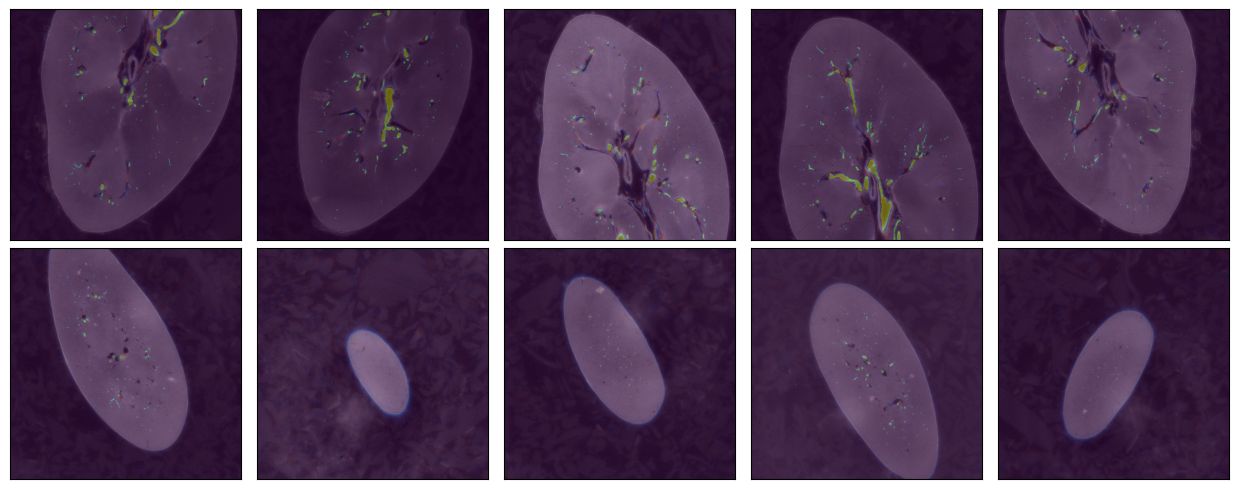

In [18]:
display_batch(batch)

# 10. Loss Fn 📉

In [19]:
from segmentation_models.base import functional as F
import tensorflow.keras.backend as K

kwargs = {}
kwargs["backend"] = K  # set tensorflow.keras as backend


def dice_coef(y_true, y_pred):
    """Dice coefficient"""
    dice = F.f_score(
        y_true,
        y_pred,
        beta=1,
        smooth=1e-5,
        per_image=False,
        threshold=0.5,
        **kwargs,
    )
    return dice


def tversky(y_true, y_pred, axis=(0, 1, 2), alpha=0.3, beta=0.7, smooth=0.0001):
    "Tversky metric"
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    tp = tf.math.reduce_sum(y_true * y_pred, axis=axis) # calculate True Positive
    fn = tf.math.reduce_sum(y_true * (1 - y_pred), axis=axis) # calculate False Negative
    fp = tf.math.reduce_sum((1 - y_true) * y_pred, axis=axis) # calculate False Positive
    tv = (tp + smooth) / (tp + alpha * fn + beta * fp + smooth) # calculate tversky
    tv = tf.math.reduce_mean(tv)
    return tv


def tversky_loss(y_true, y_pred):
    "Tversky Loss"
    return 1 - tversky(y_true, y_pred)


def focal_tversky_loss(y_true, y_pred, gamma=0.75):
    "Focal Tversky Loss: Focal Loss + Tversky Loss"
    tv = tversky(y_true, y_pred)
    return K.pow((1 - tv), gamma)


# Register custom objects
custom_objs = {
    "dice_loss": sm.losses.dice_loss,
    "dice_coef": dice_coef,
    "bce_dice_loss": sm.losses.bce_dice_loss,
    "bce_jaccard_loss": sm.losses.bce_jaccard_loss,
    "tversky_loss": tversky_loss,
    "focal_tversky_loss": focal_tversky_loss,
    "jaccard_loss": sm.losses.jaccard_loss,
    "precision": sm.metrics.precision,
    "recall": sm.metrics.recall,
}
tf.keras.utils.get_custom_objects().update(custom_objs)

# 11. LR Schedule ⚓
* Learning Rate scheduler for transfer learning.
* The learning rate starts from initial_learning_rate, then decreases to aminimum_learning_rate using different methods namely,
    * ReduceLROnPlateau: Reduce lr when score isn't improving.
    * CosineDecay: Follow Cosine graph to reduce lr.
    * ExponentialDecay: Reduce lr exponentially.

In [20]:
def get_lr_callback():
    if CFG.lr_schedule == "ReduceLROnPlateau":
        lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.1,
            patience=int(CFG.patience / 2),
            min_lr=CFG.lr / 1e2,
        )
    elif CFG.lr_schedule == "CosineDecay":
        lr_schedule = tf.keras.experimental.CosineDecay(
            initial_learning_rate=CFG.lr, decay_steps=CFG.epochs + 2, alpha=CFG.lr / 1e2
        )
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=0)
    elif CFG.lr_schedule == "ExponentialDecay":
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=CFG.lr,
            decay_steps=CFG.epochs + 2,
            decay_rate=0.05,
            staircase=False,
        )
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=0)
    return lr_schedule

# 12. TransUnet 🤖
TransUNet: Transformers Make Strong Encoders for Medical Image Segmentation

In a nutshell, this work shows how to convert a UNet into a so-called TransUNet by using a visual transformer (ViT) network in the encoder. Details of the architecture are in Figure below. As opposed to other methods which use a pure transformer-based encoder to convert the input image into a latent vector. A series of convolutions (much like in the original UNet) is used to convert the input image into a set of lower-resolution feature maps which are then encode with a ViT. So, main components fo TransUNet are,

1. Encoder (Pure or Hybrid)
    * CNN
    * Transformer
2. Decoder
    * CNN
3. Skip Connection in Hybrid
    * Connection betwween CNN Encoder & CNN Decoder

## utils

In [21]:
def apply_embedding_weights(target_layer, source_weights):
    """Apply embedding weights to a target layer.

    Args:
        target_layer: The target layer to which weights will
            be applied.
        source_weights: The source weights, which will be
            resized as necessary.
    """
    expected_shape = target_layer.weights[0].shape
    if expected_shape == source_weights.shape:
        grid = source_weights
    elif expected_shape[1] == source_weights.shape[1] - 1:
        grid = source_weights[:, 1:]
    else:
        _, grid = source_weights[0, :1], source_weights[0, 1:]
        sin = int(np.sqrt(grid.shape[0]))
        sout = int(np.sqrt(expected_shape[1]))
        warnings.warn(
            "Resizing position embeddings from " f"{sin} to {sout}",
            UserWarning,
        )
        zoom = (sout / sin, sout / sin, 1)
        grid = scipy.ndimage.zoom(grid.reshape(sin, sin, -1), zoom, order=1).reshape(
            1, sout * sout, -1
        )
    target_layer.set_weights([grid])


def load_weights_numpy(model, params_path):
    """Load weights saved using Flax as a numpy array.

    Args:
        model: A Keras model to load the weights into.
        params_path: Filepath to a numpy archive.
    """
    params_dict = np.load(
        params_path, allow_pickle=False
    )  # pylint: disable=unexpected-keyword-arg
    source_keys = list(params_dict.keys())

    source_keys_used = []
    n_transformers = len(
        set(
            "/".join(k.split("/")[:2])
            for k in source_keys
            if k.startswith("Transformer/encoderblock_")
        )
    )
    n_transformers_out = sum(
        l.name.startswith("Transformer/encoderblock_") for l in model.layers
    )
    assert n_transformers == n_transformers_out, (
        f"Wrong number of transformers ("
        f"{n_transformers_out} in model vs. {n_transformers} in weights)."
    )

    matches = []
    for tidx in range(n_transformers):
        encoder = model.get_layer(f"Transformer/encoderblock_{tidx}")
        source_prefix = f"Transformer/encoderblock_{tidx}"
        matches.extend(
            [
                {
                    "layer": layer,
                    "keys": [
                        f"{source_prefix}/{norm}/{name}" for name in ["scale", "bias"]
                    ],
                }
                for norm, layer in [
                    ("LayerNorm_0", encoder.layernorm1),
                    ("LayerNorm_2", encoder.layernorm2),
                ]
            ]
            + [
                {
                    "layer": encoder.mlpblock.get_layer(
                        f"{source_prefix}/Dense_{mlpdense}"
                    ),
                    "keys": [
                        f"{source_prefix}/MlpBlock_3/Dense_{mlpdense}/{name}"
                        for name in ["kernel", "bias"]
                    ],
                }
                for mlpdense in [0, 1]
            ]
            + [
                {
                    "layer": layer,
                    "keys": [
                        f"{source_prefix}/MultiHeadDotProductAttention_1/{attvar}/{name}"
                        for name in ["kernel", "bias"]
                    ],
                    "reshape": True,
                }
                for attvar, layer in [
                    ("query", encoder.att.query_dense),
                    ("key", encoder.att.key_dense),
                    ("value", encoder.att.value_dense),
                    ("out", encoder.att.combine_heads),
                ]
            ]
        )

    # Embedding kernel and bias
    matches.append(
        {
            "layer": model.get_layer("embedding"),
            "keys": [f"embedding/{name}" for name in ["kernel", "bias"]],
        }
    )

    matches.append(
        {
            "layer": model.get_layer("Transformer/encoder_norm"),
            "keys": [f"Transformer/encoder_norm/{name}" for name in ["scale", "bias"]],
        }
    )
    apply_embedding_weights(
        target_layer=model.get_layer("Transformer/posembed_input"),
        source_weights=params_dict["Transformer/posembed_input/pos_embedding"],
    )
    source_keys_used.append("Transformer/posembed_input/pos_embedding")
    for match in matches:
        source_keys_used.extend(match["keys"])
        source_weights = [params_dict[k] for k in match["keys"]]
        if match.get("reshape", False):
            source_weights = [
                source.reshape(expected.shape)
                for source, expected in zip(
                    source_weights, match["layer"].get_weights()
                )
            ]
        match["layer"].set_weights(source_weights)


# Encoder
Key components of Encoder are,

AddPositionEmbs
MultiHeadSelfAttention
TransformerBlock
ResNet_Embeddings

In [22]:
class AddPositionEmbs(tfkl.Layer):
    """Adds (optionally learned) positional embeddings to the inputs."""

    def __init__(self, trainable=True, **kwargs):
        super().__init__(trainable=trainable, **kwargs)
        self.trainable = trainable

    def build(self, input_shape):
        assert (
            len(input_shape) == 3
        ), f"Number of dimensions should be 3, got {len(input_shape)}"
        self.pe = tf.Variable(
            name="pos_embedding",
            initial_value=tf.random_normal_initializer(stddev=0.06)(
                shape=(1, input_shape[1], input_shape[2])
            ),
            dtype="float32",
            trainable=self.trainable,
        )

    def call(self, inputs):
        return inputs + tf.cast(self.pe, dtype=inputs.dtype)


class MultiHeadSelfAttention(tfkl.Layer):
    def __init__(self, *args, trainable=True, n_heads, **kwargs):
        super().__init__(trainable=trainable, *args, **kwargs)
        self.n_heads = n_heads

    def build(self, input_shape):
        hidden_size = input_shape[-1]
        n_heads = self.n_heads
        if hidden_size % n_heads != 0:
            raise ValueError(
                f"embedding dimension = {hidden_size} should be divisible by number of heads = {n_heads}"
            )
        self.hidden_size = hidden_size
        self.projection_dim = hidden_size // n_heads
        self.query_dense = tfkl.Dense(hidden_size, name="query")
        self.key_dense = tfkl.Dense(hidden_size, name="key")
        self.value_dense = tfkl.Dense(hidden_size, name="value")
        self.combine_heads = tfkl.Dense(hidden_size, name="out")

    # pylint: disable=no-self-use
    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], score.dtype)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.n_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)

        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.hidden_size))
        output = self.combine_heads(concat_attention)
        return output, weights


class TransformerBlock(tfkl.Layer):
    """Implements a Transformer block."""

    def __init__(self, *args, n_heads, mlp_dim, dropout, trainable=True, **kwargs):
        super().__init__(*args, trainable=trainable, **kwargs)
        self.n_heads = n_heads
        self.mlp_dim = mlp_dim
        self.dropout = dropout

    def build(self, input_shape):
        self.att = MultiHeadSelfAttention(
            n_heads=self.n_heads,
            name="MultiHeadDotProductAttention_1",
        )
        self.mlpblock = tfk.Sequential(
            [
                tfkl.Dense(
                    self.mlp_dim, activation="linear", name=f"{self.name}/Dense_0"
                ),
                tfkl.Lambda(lambda x: tfk.activations.gelu(x, approximate=False))
                if hasattr(tfk.activations, "gelu")
                else tfkl.Lambda(lambda x: tfa.activations.gelu(x, approximate=False)),
                tfkl.Dropout(self.dropout),
                tfkl.Dense(input_shape[-1], name=f"{self.name}/Dense_1"),
                tfkl.Dropout(self.dropout),
            ],
            name="MlpBlock_3",
        )
        self.layernorm1 = tfkl.LayerNormalization(epsilon=1e-6, name="LayerNorm_0")
        self.layernorm2 = tfkl.LayerNormalization(epsilon=1e-6, name="LayerNorm_2")
        self.dropout = tfkl.Dropout(self.dropout)

    def call(self, inputs, training):
        x = self.layernorm1(inputs)
        x, weights = self.att(x)
        x = self.dropout(x, training=training)
        x = x + inputs
        y = self.layernorm2(x)
        y = self.mlpblock(y)
        return x + y, weights


def resnet_embeddings(x, image_size=912, n_skip=3):
    """Get resnet embeddings for Decoder"""
    resnet50v2 = tfk.applications.ResNet50V2(
        weights="imagenet", include_top=False, input_shape=(image_size, image_size, 3)
    )
    _ = resnet50v2(x)
    layers = ["conv3_block4_preact_relu", "conv2_block3_preact_relu", "conv1_conv"]
    features = []
    if n_skip > 0:
        for l in layers:
            features.append(resnet50v2.get_layer(l).output)
    return resnet50v2, features

# Decoder
Key components of Decoders are,

SegmentationHead
Conv2DReLu
DecoderBlock
DecoderCup

In [23]:
L2_WEIGHT_DECAY = 1e-4

class SegmentationHead(tfkl.Layer):
    def __init__(
        self,
        name="seg_head",
        num_classes=9,
        kernel_size=1,
        final_act="sigmoid",
        **kwargs
    ):
        super(SegmentationHead, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.kernel_size = kernel_size
        self.final_act = final_act

    def build(self, input_shape):
        self.conv = tfkl.Conv2D(
            filters=self.num_classes,
            kernel_size=self.kernel_size,
            padding="same",
            kernel_regularizer=tfk.regularizers.L2(L2_WEIGHT_DECAY),
            kernel_initializer=tfk.initializers.LecunNormal(),
        )
        self.act = tfkl.Activation(self.final_act)

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.act(x)
        return x


class Conv2DReLu(tfkl.Layer):
    def __init__(self, filters, kernel_size, padding="same", strides=1, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.padding = padding
        self.strides = strides

    def build(self, input_shape):
        self.conv = tfkl.Conv2D(
            filters=self.filters,
            kernel_size=self.kernel_size,
            strides=self.strides,
            padding=self.padding,
            use_bias=False,
            kernel_regularizer=tfk.regularizers.L2(L2_WEIGHT_DECAY),
            kernel_initializer="lecun_normal",
        )

        self.bn = tfkl.BatchNormalization(momentum=0.9, epsilon=1e-5)

    def call(self, inputs):
        x = self.conv(inputs)
        x = self.bn(x)
        x = tf.nn.relu(x)
        return x

class DecoderBlock(tfkl.Layer):
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        self.filters = filters

    def build(self, input_shape):
        self.conv1 = Conv2DReLu(filters=self.filters, kernel_size=3)
        self.conv2 = Conv2DReLu(filters=self.filters, kernel_size=3)
        self.upsampling = tfkl.UpSampling2D(size=2, interpolation="bilinear")

    def call(self, inputs, skip=None):
        x = self.upsampling(inputs)
        if skip is not None:
            # Resize skip to match x dimensions
            skip = tf.image.resize(skip, [tf.shape(x)[1], tf.shape(x)[2]], method='bilinear')
            x = tf.concat([x, skip], axis=-1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class DecoderCup(tfkl.Layer):
    def __init__(self, decoder_channels, n_skip=3, **kwargs):
        super().__init__(**kwargs)
        self.decoder_channels = decoder_channels
        self.n_skip = n_skip

    def build(self, input_shape):
        self.conv_more = Conv2DReLu(filters=512, kernel_size=3)
        self.blocks = [DecoderBlock(filters=out_ch) for out_ch in self.decoder_channels]

    def call(self, hidden_states, features):
        x = self.conv_more(hidden_states)
        for i, decoder_block in enumerate(self.blocks):
            if features is not None:
                skip = features[i] if (i < self.n_skip) else None
            else:
                skip = None
            x = decoder_block(x, skip=skip)
        return x
    
    

# Model
Merge Encoder & Decoder part of TransUNet Model.

In [ ]:
MODELS_URL = "https://storage.googleapis.com/vit_models/imagenet21k/"


def load_pretrained(model, fname="R50+ViT-B_16.npz"):
    """Load model weights for a known configuration."""
    origin = MODELS_URL + fname
    local_filepath = tf.keras.utils.get_file(fname, origin, cache_subdir="weights")
    load_weights_numpy(model, local_filepath)


def TransUNet(
    image_size=912,
    patch_size=16,
    hybrid=True,
    grid=(57,57),
    resnet_n_layers=(3, 4, 9),
    hidden_size=768,
    n_layers=12,
    n_heads=12,
    mlp_dim=3072,
    dropout=0.1,
    decoder_channels=[256, 128, 64, 16],
    n_skip=3,
    num_classes=3,
    final_act="sigmoid",
    pretrain=True,
    freeze_enc_cnn=True,
    name="TransUNet",
):
    # Tranformer Encoder
    assert image_size % patch_size == 0, "image_size must be a multiple of patch_size"
    x = tf.keras.layers.Input(shape=(image_size, image_size, 3))

    #  CNN + Transformer
    if hybrid:
        grid_size = grid
        patch_size = image_size // 16 // grid_size[0]
        if patch_size == 0:
            patch_size = 1
        resnet50v2, features = resnet_embeddings(
            x, image_size=image_size, n_skip=n_skip
        )
        if freeze_enc_cnn:
            resnet50v2.trainable = False
        y = resnet50v2.get_layer("conv4_block6_preact_relu").output
        x = resnet50v2.input
    else:
        y = x
        features = None

    y = tfkl.Conv2D(
        filters=hidden_size,
        kernel_size=patch_size,
        strides=patch_size,
        padding="valid",
        name="embedding",
        trainable=not freeze_enc_cnn,
    )(y)
    y = tfkl.Reshape((y.shape[1] * y.shape[2], hidden_size))(y)
    y = AddPositionEmbs(name="Transformer/posembed_input", trainable=True)(y)

    y = tfkl.Dropout(0.1)(y)

    # Transformer/Encoder
    for n in range(n_layers):
        y, _ = TransformerBlock(
            n_heads=n_heads,
            mlp_dim=mlp_dim,
            dropout=dropout,
            name=f"Transformer/encoderblock_{n}",
            trainable=True,
        )(y)
    y = tfkl.LayerNormalization(epsilon=1e-6, name="Transformer/encoder_norm")(y)

    n_patch_sqrt = int(math.sqrt(y.shape[1]))

    y = tfkl.Reshape(target_shape=[n_patch_sqrt, n_patch_sqrt, hidden_size])(y)

    # Decoder
    if len(decoder_channels):
        y = DecoderCup(decoder_channels=decoder_channels, n_skip=n_skip)(y, features)

    # Segmentation Head
    y = SegmentationHead(num_classes=num_classes, final_act=final_act)(y)

    # Build Model
    model = tfk.models.Model(inputs=x, outputs=y, name=name)

    # Load Pretrain Weights
    if pretrain:
        load_pretrained(model)

    return model

## Build Model
Build complete model.
Select Loss, LR_Scheduling, Metrics and so on.
Compile model for training.

In [24]:
def get_model(name=CFG.model_name, loss=CFG.loss, backbone=CFG.backbone):
    model = TransUNet(image_size=CFG.image_size[0], freeze_enc_cnn=False, pretrain=True)

    lr = CFG.lr
    if CFG.optimizer == "Adam":
        opt = tf.keras.optimizers.Adam(learning_rate=lr)
    elif CFG.optimizer == "AdamW":
        opt = tfa.optimizers.AdamW(learning_rate=lr, weight_decay=lr)
    elif CFG.optimizer == "RectifiedAdam":
        opt = tfa.optimizers.RectifiedAdam(learning_rate=lr)
    else:
        raise ValueError("Wrong Optimzer Name")

    model.compile(
        optimizer=opt,
        loss=loss,
        steps_per_execution=CFG.steps_per_execution, # to reduce idle time
        metrics=[
            dice_coef,
            "precision",
            "recall",
        ],
    )
    return model

# 13.WandB 🪄

Weights & Biases

To track model's training I'll be using Weights & Biases tool. Weights & Biases (W&B) is MLOps platform for tracking our experiemnts. We can use it to Build better models faster with experiment tracking, dataset versioning, and model management.

In [25]:
if CFG.wandb:
    "login in wandb otherwise run anonymously"
    try:
        # Addo-ons > Secrets > WANDB
        from kaggle_secrets import UserSecretsClient
        user_secrets = UserSecretsClient()
        api_key = user_secrets.get_secret("WANDB")
        wandb.login(key=api_key)
        anonymous = None
    except:
        anonymous = "must"


def wandb_init(fold):
    "initialize project on wandb"
    id_ = wandb.util.generate_id() # generate random id
    config = {k: v for k, v in dict(vars(CFG)).items() if "__" not in k} # convert class to dict
    config["id"] = id_
    config["fold"] = int(fold) # np to python
    run = wandb.init(
        id=id_,
        project="uwmgi-tf",
        name=f"fold-{fold}|dim-{CFG.image_size[0]}x{CFG.image_size[1]}|model-{CFG.model_name}|backbone-{CFG.backbone}",
        config=config,
        anonymous=anonymous,
        group=CFG.comment,
        reinit=True,
        resume="allow",
    )
    return run

# 14. Training 🚅
Our model will be trained for the number of FOLDS and EPOCHS you chose in the configuration above. Each fold the model with hightest validation Dice Score will be saved and used to predict OOF and test.

In [26]:
tf.io.gfile.glob("/kaggle/input/blood-vessel-segmentation/train/kidney_1_dense/images/0000.tif")

['/kaggle/input/blood-vessel-segmentation/train/kidney_1_dense/images/0000.tif']

In [28]:
import tensorflow as tf

# Enable device placement logging
tf.debugging.set_log_device_placement(True)

# Test TensorFlow device placement
# Perform a simple operation
a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
b = tf.constant([[1.0, 1.0], [0.0, 1.0]])
# Run a matrix multiplication operation and log the device it runs on
c = tf.matmul(a, b)

print(c)


tf.Tensor(
[[1. 3.]
 [3. 7.]], shape=(2, 2), dtype=float32)


In [30]:
# Assuming CFG, get_model, strategy, REPLICAS are defined elsewhere in your code.
# Assuming train_ds and valid_ds are already defined as per your dataset preparation code.

# Initialize metrics dictionary
M = {f"val_{metric}": [] for metric in ["loss", "dice_coef", "precision", "recall"]}

NUM_TRAIN_SAMPLES = len(train_df)  # or however you calculate the total number of training samples
BATCH_SIZE = CFG.batch_size
steps_per_epoch = NUM_TRAIN_SAMPLES // BATCH_SIZE

NUM_VALID_SAMPLES = len(valid_df)  # or however you calculate the total number of validation samples
validation_steps = NUM_VALID_SAMPLES // BATCH_SIZE


# Assuming CFG.selected_folds contains the folds you want to train on
for fold in CFG.selected_folds:
    print(f"Starting training for fold {fold}")

    # Initialize or clear the TensorFlow session to free memory and resources
    K.clear_session()
    

     # Initialize wandb Run
    if CFG.wandb:
        run = wandb_init(fold)
        WandbCallback = wandb.keras.WandbCallback(save_model=False)


    with strategy.scope():
        # Create the model
        model = get_model(name=CFG.model_name, backbone=CFG.backbone, loss=CFG.loss)
    
    # Callbacks
    checkpoint_callback = ModelCheckpoint(
        f"/kaggle/working/fold-{fold}.h5",
        monitor="val_dice_coef",
        mode="max",
        save_best_only=True,
        save_weights_only=True,
        verbose=CFG.verbose
    )

    callbacks_list = [checkpoint_callback, get_lr_callback()]

    if CFG.wandb:
        # Include WandB callback if enabled
        callbacks_list.append(WandbCallback)
        
    print("#" * 65)
    print("#### FOLD:", fold)
    print(
        "#### IMAGE_SIZE: (%i, %i) | BATCH_SIZE: %i | EPOCHS: %i"
        % (CFG.image_size[0], CFG.image_size[1], BATCH_SIZE, CFG.epochs)
    )
    print(
        "#### MODEL: %s | BACKBONE: %s | LOSS: %s"
        % (CFG.model_name, CFG.backbone, CFG.loss)
    )
    print("#### NUM_TRAIN: {:,} | NUM_VALID: {:,}".format(NUM_TRAIN_SAMPLES, NUM_VALID_SAMPLES))
    print("#" * 65)

    # Train the model
    history = model.fit(
        train_ds,
        epochs=CFG.epochs if not CFG.debug else 2,
        steps_per_epoch=steps_per_epoch,  # Specify steps per epoch
        callbacks=callbacks_list,
        validation_data=valid_ds,
        validation_steps=validation_steps,  # Specify validation steps
        verbose=CFG.verbose)


    # Convert training history to DataFrame
    history_df = pd.DataFrame(history.history)

    # Load the best model weights
    model.load_weights(f"/kaggle/working/fold-{fold}.h5")

    # Evaluate the model on the validation set
    val_metrics = model.evaluate(valid_ds, return_dict=True, verbose=1)
    
    # Store validation metrics
    for metric in M.keys():
        M[metric].append(val_metrics[metric.replace("val_", "")])

    # Log validation metrics to WandB
    if CFG.wandb:
        wandb.log({f"best_{metric}": val_metrics[metric] for metric in ["dice_coef", "loss", "precision", "recall"]})
        wandb.run.finish()

    # Plot Training History
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history_df['dice_coef'], label='Train Dice Coefficient', color='orange')
    plt.plot(history_df['val_dice_coef'], label='Validation Dice Coefficient', color='blue')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Coefficient')
    plt.title(f'Training and Validation Dice Coefficient for Fold {fold}')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history_df['loss'], label='Train Loss', color='green')
    plt.plot(history_df['val_loss'], label='Validation Loss', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss for Fold {fold}')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"training_history_fold_{fold}.png")
    plt.show()

    # You can add more visualizations or logs here as needed


'dice_loss'